<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install alpaca_trade_api

     |████████████████████████████████| 103 kB 8.6 MB/s 
     |████████████████████████████████| 273 kB 46.9 MB/s 
     |████████████████████████████████| 636 kB 54.6 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 1.3 MB 48.9 MB/s 
     |████████████████████████████████| 160 kB 57.5 MB/s 
     |████████████████████████████████| 271 kB 59.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3


Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [3]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [5]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [6]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

def markethours_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_barset(ticker, interval, start = start.isoformat(), end=end.isoformat()).df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_barset(ticker, interval, start=start, end=end_new).df
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['time'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    pre_final = pd.DataFrame()
    pre_final["Open"] = stock_yr_min_df[ticker]['open']
    pre_final["High"]= stock_yr_min_df[ticker]["high"]
    pre_final["Low"] = stock_yr_min_df[ticker]["low"]
    pre_final["Close"] = stock_yr_min_df[ticker]["close"]
    pre_final["Volume"] = stock_yr_min_df[ticker]["volume"]
    pre_final["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    pre_final.index = stock_yr_min_df.index.tz_convert(TZ)
    
    final_df = pre_final.filter(["Time", "Open", "High", "Low", "Close", "Volume"], axis = 1).between_time('9:29', '16:05')
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

In [7]:
ticker = "WMT" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = 365 # Size of training set
val_day_int = 0 # Size of validation set
test_day_int = 60 # Size of test set
offset_day_int = 365 # Number of days to off set the training data
train, val, test, full, offset, complete, traintest_day, testval_day = markethours_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/5Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/5Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/5Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/5Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/5Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/5Min 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v1/bars/5Min 3 more time(s)...


In [8]:
train.head(25)

,Time,Open,High,Low,Close,Volume
time,,,,,,
2019-11-21 14:10:00-05:00,2019-11-21 14:10:00-05:00,119.400,119.440,119.380,119.410,1383
2019-11-21 14:15:00-05:00,2019-11-21 14:15:00-05:00,119.425,119.470,119.425,119.470,727
2019-11-21 14:20:00-05:00,2019-11-21 14:20:00-05:00,119.455,119.455,119.380,119.420,1465
2019-11-21 14:25:00-05:00,2019-11-21 14:25:00-05:00,119.430,119.430,119.370,119.420,1870
2019-11-21 14:30:00-05:00,2019-11-21 14:30:00-05:00,119.420,119.490,119.420,119.440,34357
2019-11-21 14:35:00-05:00,2019-11-21 14:35:00-05:00,119.440,119.455,119.420,119.445,1800
2019-11-21 14:40:00-05:00,2019-11-21 14:40:00-05:00,119.470,119.590,119.465,119.590,3409
2019-11-21 14:45:00-05:00,2019-11-21 14:45:00-05:00,119.600,119.660,119.570,119.640,7013
2019-11-21 14:50:00-05:00,2019-11-21 14:50:00-05:00,119.630,119.760,119.630,119.720,1571


In [12]:
# test split pd DataFrame into arrays for running CNN on
test_train_tonp = train[["Time", "Open", "High", "Low", "Close", "Volume"]]
test_train_array = test_train_tonp.to_numpy()

In [13]:
cutoff = len(test_train_array) % 24
test_train_array = test_train_array[:-cutoff]
len(test_train_array) % 24

0

In [20]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
  

np.set_printoptions(linewidth=100)
print(blockshaped(test_train_array, 24, 6)[1])

[[Timestamp('2019-11-22 09:40:00-0500', tz='US/Eastern') 119.72 119.74 119.63 119.74 860]
 [Timestamp('2019-11-22 09:45:00-0500', tz='US/Eastern') 119.54 119.595 119.46 119.595 1865]
 [Timestamp('2019-11-22 09:50:00-0500', tz='US/Eastern') 119.7 119.735 119.59 119.71 1200]
 [Timestamp('2019-11-22 09:55:00-0500', tz='US/Eastern') 119.75 119.76 119.67 119.67 491]
 [Timestamp('2019-11-22 10:00:00-0500', tz='US/Eastern') 119.7 119.83 119.65 119.65 983]
 [Timestamp('2019-11-22 10:05:00-0500', tz='US/Eastern') 119.7 119.77 119.7 119.735 405]
 [Timestamp('2019-11-22 10:10:00-0500', tz='US/Eastern') 119.68 119.85 119.68 119.83 1200]
 [Timestamp('2019-11-22 10:15:00-0500', tz='US/Eastern') 119.75 119.85 119.66 119.74 1904]
 [Timestamp('2019-11-22 10:20:00-0500', tz='US/Eastern') 119.69 119.78 119.64 119.75 2179]
 [Timestamp('2019-11-22 10:25:00-0500', tz='US/Eastern') 119.83 119.83 119.735 119.735 800]
 [Timestamp('2019-11-22 10:30:00-0500', tz='US/Eastern') 119.72 119.72 119.58 119.58 2041]
 [

In [11]:
def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
    if shuffle:
        ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
    else:
        ds = ds.cache().batch(batch_size).repeat()

    return ds

def create_window_dataset(ds, window_size):
    windowed_dataset = []

    for i in range(window_size, ds.shape[0] + 1):
        windowed_dataset.append(ds[i - window_size:])

        
    return np.array(windowed_dataset)

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pd.DataFrame()

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_val = scaler.fit_transform(val[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test = scaler.fit_transform(test[['Open', 'High', 'Low', 'Close', 'Volume']])

In [43]:
WINDOW_SIZE = 25
BATCH_SIZE = 1

windowed_dataset_train = create_window_dataset(scaled_train[:, 0:-1], WINDOW_SIZE)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [46]:
windowed_dataset_train[1].shape

(67652, 4)

In [ ]:
windowed_dataset_train, labels_train = create_window_dataset(train_dataset_normalized, train_dataset[:, -1], WINDOW_SIZE)
train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000)
unshuffled_train_set = tf_dataset(windowed_dataset_train, labels_train, BATCH_SIZE, 1000, False)

windowed_dataset_validation, labels_validation = create_window_dataset(cross_validation_dataset_normalized, cross_validation_dataset[:, -1], WINDOW_SIZE)
cross_validation_set = tf_dataset(windowed_dataset_validation, labels_validation, BATCH_SIZE, 1000, False)

windowed_dataset_dev, labels_dev = create_window_dataset(dev_dataset_normalized, dev_dataset[:, -1], WINDOW_SIZE)
dev_set = tf_dataset(windowed_dataset_dev, labels_dev, 1, 1000, False)

In [30]:
train.values

array([[Timestamp('2016-04-25 10:30:00-0400', tz='US/Eastern'), 68.81,
        68.88, ..., 68.88, 52095, 68.824087],
       [Timestamp('2016-04-25 10:35:00-0400', tz='US/Eastern'), 68.88,
        68.92, ..., 68.905, 55508, 68.901144],
       [Timestamp('2016-04-25 10:40:00-0400', tz='US/Eastern'), 68.91,
        68.9301, ..., 68.9, 37356, 68.911471],
       ...,
       [Timestamp('2019-01-18 17:00:00-0500', tz='US/Eastern'), 97.73,
        97.73, ..., 97.73, 100, 97.73],
       [Timestamp('2019-01-18 17:25:00-0500', tz='US/Eastern'), 97.7299,
        97.73, ..., 97.73, 627, 97.729968],
       [Timestamp('2019-01-18 19:55:00-0500', tz='US/Eastern'), 97.73,
        97.73, ..., 97.73, 100, 97.73]], dtype=object)

In [26]:
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

(5, 3, 3) (5, 2, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [[ 40  45  85]
 [ 50  55 105]]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [[ 50  55 105]
 [ 60  65 125]]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [[ 60  65 125]
 [ 70  75 145]]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [[ 70  75 145]
 [ 80  85 165]]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [[ 80  85 165]
 [ 90  95 185]]


In [29]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [23]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [24]:
x_train, y_train = create_dataset(train)

TypeError: ignored

In [8]:
print(f'Training Days: {train_day_int}, Set Start: {train.index[0].strftime("%d-%b-%Y")}, End: {train.index[-1].strftime("%d-%b-%Y")}, Shape: {train.shape}')
print(f'Validation Days: {val_day_int}, Set Start: {val.index[0].strftime("%d-%b-%Y")}, End: {val.index[-1].strftime("%d-%b-%Y")}, Shape: {val.shape}')
print(f'Testing Days: {test_day_int}, Start: {test.index[0].strftime("%d-%b-%Y")}, End: {test.index[-1].strftime("%d-%b-%Y")}, Shape: {test.shape}')

Training Days: 1000, Set Start: 25-Apr-2016, End: 18-Jan-2019, Shape: (67653, 7)
Validation Days: 365, Set Start: 22-Jan-2019, End: 17-Jan-2020, Shape: (25027, 7)
Testing Days: 365, Start: 21-Jan-2020, End: 19-Jan-2021, Shape: (31494, 7)


In [9]:
print(f'Number of Rows Between all Sets: {(train.shape[0] + val.shape[0] + test.shape[0])}, Shape of Full Set: {full.shape[0]}')

Number of Rows Between all Sets: 124174, Shape of Full Set: 124174


# Loading and Preparing The Data

In [10]:
# create target from OHLC and Volume Data
def buildTargets(full_df = full, train_observations = train.shape[0], 
                 val_observations = val.shape[0], 
                 test_observations = test.shape[0], 
                 shift_2hour = 24,
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 252 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 25)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)

  #print(len(full_df.Close), len(volatility))

  targets = ["flat"] * len(full_df.Close)

  targets = np.where(full_df.Close.shift(-shift_2hour) >= (full_df.Close * (1 + alph * volatility)), 
           "up", targets)
  
  targets = np.where(full_df.Close.shift(-shift_2hour) <= (full_df.Close * (1 - alph * volatility)), 
           "down", targets)

  train_split = train_observations
  val_split = train_observations + val_observations
  test_split = train_observations + val_observations + test_observations

  train_targets = targets[:train_split]
  val_targets = targets[train_split:val_split]
  test_targets = targets[val_split:test_split]
  full_targets = targets

  return train_targets, val_targets, test_targets, full_targets

In [11]:
# print(buildTargets.__doc__)
train_targets, val_targets, test_targets, full_targets = buildTargets()

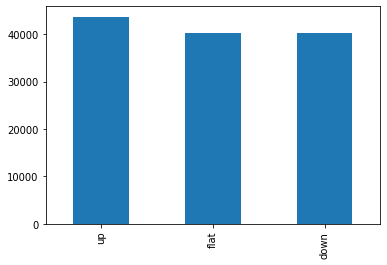

In [12]:
plot_df = pd.DataFrame(full_targets, columns=["FuturePrice"])
plot_df["FuturePrice"].value_counts().plot(kind = 'bar')

# Mulitclass Classification (None CDT 1D CNN)

In [13]:
full.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'VolumeWeightedAvgPrice'],
      dtype='object')

In [14]:
full["Open"]

timestamp
2016-04-25 10:30:00-04:00     68.81
2016-04-25 10:35:00-04:00     68.88
2016-04-25 10:40:00-04:00     68.91
2016-04-25 10:45:00-04:00     68.90
2016-04-25 10:50:00-04:00     68.94
                              ...  
2021-01-19 08:50:00-05:00    145.00
2021-01-19 09:00:00-05:00    144.98
2021-01-19 09:10:00-05:00    144.98
2021-01-19 09:15:00-05:00    144.93
2021-01-19 09:20:00-05:00    144.81
Name: Open, Length: 124174, dtype: float64

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pd.DataFrame()

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_val = scaler.fit_transform(val[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test = scaler.fit_transform(test[['Open', 'High', 'Low', 'Close', 'Volume']])

In [16]:
train_targets_df = pd.DataFrame(train_targets)
val_targets_df = pd.DataFrame(val_targets)
test_targets_df = pd.DataFrame(test_targets)

class2idx = {
    "up":0,
    "flat":1,
    "down":2,
}

idx2class = {v: k for k, v in class2idx.items()}

train_targets_df.replace(class2idx, inplace=True)
val_targets_df.replace(class2idx, inplace=True)
test_targets_df.replace(class2idx, inplace=True)

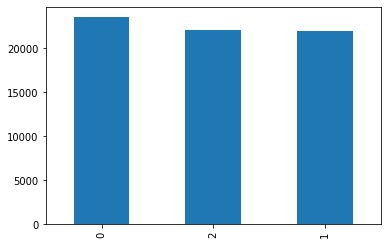

In [17]:
train_targets_df[0].value_counts().plot(kind = 'bar')

In [18]:
X_train = np.array(scaled_train)
X_val = np.array(scaled_val)
X_test= np.array(scaled_test)

y_train = np.array(train_targets_df[0])
y_val = np.array(val_targets_df[0])
y_test = np.array(test_targets_df[0])

In [19]:
print(f'Type of X Train: {type(X_train)}, Length of X: {X_train.shape}')
print(f'Type of y Train: {type(y_train)}, Length of y: {y_train.shape}')
print(f'Type of X Val: {type(X_val)}, Length of X: {X_val.shape}')
print(f'Type of y Val: {type(y_val)}, Length of y: {y_val.shape}')
print(f'Type of X Val: {type(X_test)}, Length of X: {X_test.shape}')
print(f'Type of y Val: {type(y_test)}, Length of y: {y_test.shape}')

Type of X Train: <class 'numpy.ndarray'>, Length of X: (67653, 5)
Type of y Train: <class 'numpy.ndarray'>, Length of y: (67653,)
Type of X Val: <class 'numpy.ndarray'>, Length of X: (25027, 5)
Type of y Val: <class 'numpy.ndarray'>, Length of y: (25027,)
Type of X Val: <class 'numpy.ndarray'>, Length of X: (31494, 5)
Type of y Val: <class 'numpy.ndarray'>, Length of y: (31494,)


In [20]:
np.asarray(train)

array([[Timestamp('2016-04-25 10:30:00-0400', tz='US/Eastern'), 68.81,
        68.88, ..., 68.88, 52095, 68.824087],
       [Timestamp('2016-04-25 10:35:00-0400', tz='US/Eastern'), 68.88,
        68.92, ..., 68.905, 55508, 68.901144],
       [Timestamp('2016-04-25 10:40:00-0400', tz='US/Eastern'), 68.91,
        68.9301, ..., 68.9, 37356, 68.911471],
       ...,
       [Timestamp('2019-01-18 17:00:00-0500', tz='US/Eastern'), 97.73,
        97.73, ..., 97.73, 100, 97.73],
       [Timestamp('2019-01-18 17:25:00-0500', tz='US/Eastern'), 97.7299,
        97.73, ..., 97.73, 627, 97.729968],
       [Timestamp('2019-01-18 19:55:00-0500', tz='US/Eastern'), 97.73,
        97.73, ..., 97.73, 100, 97.73]], dtype=object)

In [ ]:
class ClassifierDataset():
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
scaled_train.shape[1]

5

In [ ]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = scaled_train.shape[1]
NUM_CLASSES = 3

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=5, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
  
  # TRAINING
  train_epoch_loss = 0
  train_epoch_acc = 0


  model.train()
  for X_train_batch, y_train_batch in train_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
      optimizer.zero_grad()
      
      y_train_pred = model(X_train_batch)
      
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = multi_acc(y_train_pred, y_train_batch)
      
      train_loss.backward()
      optimizer.step()
      
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()
      
      
  # VALIDATION    
  with torch.no_grad():
      
      val_epoch_loss = 0
      val_epoch_acc = 0
      
      model.eval()
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = model(X_val_batch)
                      
          val_loss = criterion(y_val_pred, y_val_batch)
          val_acc = multi_acc(y_val_pred, y_val_batch)
          
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()

  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))
  accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
  accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                            

  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.03773 | Val Loss: 18.28548 | Train Acc: 46.339| Val Acc: 35.978
Epoch 002: | Train Loss: 1.03568 | Val Loss: 14.71919 | Train Acc: 46.572| Val Acc: 35.846
Epoch 003: | Train Loss: 1.03342 | Val Loss: 16.51808 | Train Acc: 46.793| Val Acc: 36.061
Epoch 004: | Train Loss: 1.03213 | Val Loss: 21.83980 | Train Acc: 46.823| Val Acc: 36.041
Epoch 005: | Train Loss: 1.03002 | Val Loss: 22.58325 | Train Acc: 47.167| Val Acc: 35.862
Epoch 006: | Train Loss: 1.02964 | Val Loss: 22.80922 | Train Acc: 47.228| Val Acc: 35.958
Epoch 007: | Train Loss: 1.02630 | Val Loss: 22.72420 | Train Acc: 47.528| Val Acc: 35.934
Epoch 008: | Train Loss: 1.02479 | Val Loss: 22.38807 | Train Acc: 47.576| Val Acc: 35.902
Epoch 009: | Train Loss: 1.02515 | Val Loss: 22.53223 | Train Acc: 47.479| Val Acc: 36.077
Epoch 010: | Train Loss: 1.02227 | Val Loss: 23.79687 | Train Acc: 47.802| Val Acc: 35.974
Epoch 011: | Train Loss: 1.02061 | Val Loss: 24.85404 | Train Acc: 47.934| Val Acc: 35.866

KeyboardInterrupt: ignored

# APPENDIX

In [ ]:
plot_df = pd.DataFrame(full_targets, columns=["FuturePrice"])

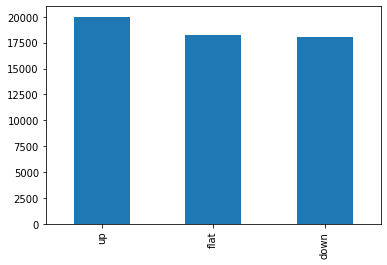

In [ ]:
plot_df["FuturePrice"].value_counts().plot(kind = 'bar')

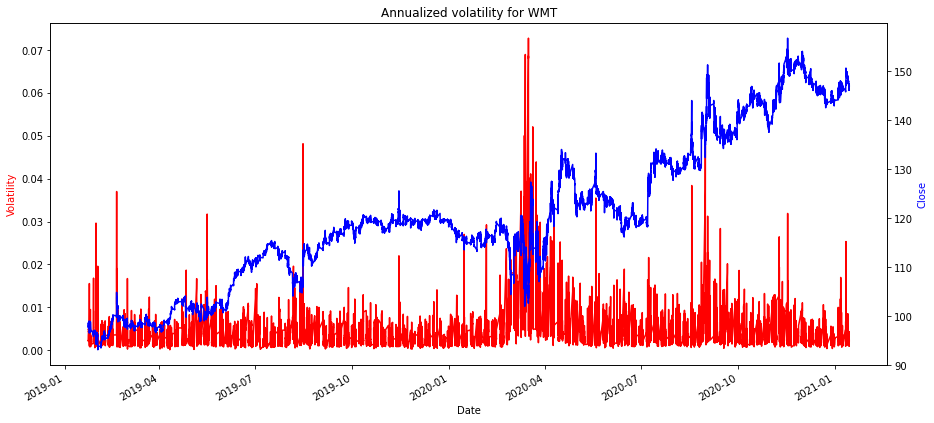

In [ ]:
def buildTargets_VolOnly(full_df = full, train_observations = train.shape[0], 
                         val_observations = val.shape[0], 
                         test_observations = test.shape[0], 
                         alph = 0.55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift(1)))
  returns.fillna(0, inplace=True)
  #volatility = returns.std()*np.sqrt(volity_int)
  volatility = returns.rolling(window=volity_int).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
plt.show()

In [ ]:
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale our data to help the algorithm converge faster
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
full.drop(columns=['Time', ])

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
data=load_breast_cancer(as_frame=True)

In [ ]:
data.target

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64